In [1]:
%matplotlib inline
from matplotlib.pylab import figure,plot,legend,xlabel,ylabel,imshow,cm,axis
import matplotlib.pylab as plt

In [2]:
from Connect4 import *
from tqdm.notebook import tqdm

Version:  0.2.41


In [3]:
import numpy as np

In [4]:
from nn import NumpyNetTable

Version  1.0.6
nn 0 0 2


In [5]:
def all_possible_moves():
    all_moves=[]
    for move in range(7):
        all_moves.append(move)
            
    return all_moves

def state_to_X(state):  
    import numpy as np
    N2=len(state)
    arr=np.zeros((1,N2))  # number of samples, size
    for i in range(N2):
        if state[i]==0:
            arr[0,i]=0
        elif state[i]==1:
            arr[0,i]=1
        elif state[i]==2:
            arr[0,i]=-1
                     
    return arr

In [6]:
print(all_possible_moves())

[0, 1, 2, 3, 4, 5, 6]


In [7]:
state=initial_state()
initial_X=state_to_X(state)
all_moves=all_possible_moves()

print(state)
print(initial_X)

 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [8]:
Q=NumpyNetTable(state_to_X,all_possible_moves(),
                {
                    'input':initial_X.shape[1],               # number of inputs
                    'hidden':[(5,'logistic'),],
                    'output':(len(all_moves),'tanh'),  # number of moves
                    'cost':'mse',
                })

In [9]:
Q.output(state)

[array([0.49975002, 0.49975   , 0.49975004, 0.49975   , 0.49975   ]),
 array([-0.54435571,  0.04930941, -0.5427026 , -0.31654501, -0.55123811,
         0.38550318, -0.24225424])]

In [10]:
Q[state]

{0: -0.5443557075420827,
 1: 0.049309409372792025,
 2: -0.5427026024890943,
 3: -0.3165450052199109,
 4: -0.5512381129350138,
 5: 0.38550317807725343,
 6: -0.24225424101813334}

In [11]:
target=[]
actual_moves=valid_moves(state,1)
for i,move in enumerate(all_moves):
    if move in actual_moves:  # keep the old values for valid moves
        target.append(1)
    else:
        target.append(-1)  # lose with illegal move

In [12]:
print(str(target).replace(" 1,","    +1,   "))

[1,    +1,       +1,       +1,       +1,       +1,    1]


In [13]:
np.array(target)

array([1, 1, 1, 1, 1, 1, 1])

In [14]:
Q[state]=target

In [15]:
Q[state]

{0: -0.5418793653981082,
 1: 0.051892446148988476,
 2: -0.5403078931416543,
 3: -0.3137310650617132,
 4: -0.5487272533523244,
 5: 0.38620747757492396,
 6: -0.23924419430559754}

In [16]:
def QNN_move(state,player,info):
    Q=info.Q
    last_action=info.last_action
    last_state=info.last_state
    
    alpha=info.alpha  # learning rate
    gamma=info.gamma  # memory 
    epsilon=info.epsilon  # probability of doing random move
    
    new_state=state
    new_actual_moves=valid_moves(new_state,player)
    new_action_values=Q[new_state]
    new_values=[new_action_values[move] for move in new_actual_moves] 
    
    if random.random()<epsilon:  # random move
        action=random_choice(new_actual_moves)
    else:
        action=top_choice(new_actual_moves,weights=new_values)
            
            
#         # Ask the model for the Q values of the old state (inference)
#         old_state_Q_values = self.get_Q(old_state)

#         # Ask the model for the Q values of the new state (inference)
#         new_state_Q_values = self.get_Q(new_state)

#         # Real Q value for the action we took. This is what we will train towards.
#         old_state_Q_values[action] = reward + self.discount * np.amax(new_state_Q_values)
        
    if alpha==0:  # no learning
        return action

    if not last_action is None:  # anything but the first move
        r=0.0  # no reward middle of game
        possible_moves=Q.all_moves
        
        old_state=last_state

        old_actual_moves=valid_moves(old_state,player)
        old_action_values=Q[old_state]
        old_values=[old_action_values[move] for move in old_actual_moves] 
        
        
        target=[]
        for i,move in enumerate(possible_moves):
            if move==last_action:
                target.append(r + gamma*max(new_values))  # max of actually available values
            elif move in old_actual_moves:  # keep the old values for valid moves
                target.append(old_action_values[move])
            else:
                target.append(-1)  # lose with illegal move

        Q[old_state]=target
        
    return action

def QNN_post(status,player,info):
    Q=info.Q
    last_action=info.last_action
    last_state=info.last_state
    
    alpha=info.alpha  # learning rate
    gamma=info.gamma  # memory 
    epsilon=info.epsilon  # probability of doing random move

    if alpha==0.0:  # no update if not learning
        return
    
    if status=='lose':
        r=-1.0
    elif status=='win':
        r=1.0
    elif status=='stalemate':
        r=0.5
    else:
        r=0.0
        
    if not last_action is None:  # anything but the first move
        possible_moves=Q.all_moves
        old_state=last_state

        old_actual_moves=valid_moves(old_state,player)
        old_action_values=Q[old_state]
        old_values=[old_action_values[move] for move in old_actual_moves] 
        
        
        target=[]
        for i,move in enumerate(possible_moves):
            if move==last_action:
                target.append(r)  # just the reward
            elif move in old_actual_moves:  # keep the old values for valid moves
                target.append(old_action_values[move])
            else:
                target.append(-1)  # lose with illegal move

        Q[old_state]=target


In [17]:
Q1_agent=Agent(QNN_move)
Q1_agent.post=QNN_post

Q1_agent.alpha=0.03  # learning rate
Q1_agent.gamma=0.9  # memory
Q1_agent.epsilon=0.1  # chance of making a random move

Q1_agent.original_alpha=Q1_agent.alpha

Q2_agent=Agent(QNN_move)
Q2_agent.post=QNN_post

Q2_agent.alpha=0.03  # learning rate
Q2_agent.gamma=0.9  # memory
Q2_agent.epsilon=0.1  # chance of making a random move

Q2_agent.original_alpha=Q2_agent.alpha


### set the Q tables for the agents

In [18]:
state=initial_state()
initial_X=state_to_X(state)
all_moves=all_possible_moves()

print(state)
print(initial_X)

Q1_agent.Q=NumpyNetTable(state_to_X,all_possible_moves(),
                {
                    'input':initial_X.shape[1],               # number of inputs
                    'hidden':[(20,'logistic'),],
                    'hidden':[(20,'logistic'),],
                    'output':(len(all_moves),'tanh'),  # number of moves
                    'cost':'mse',
                },
                        verbose=False)

Q2_agent.Q=NumpyNetTable(state_to_X,all_possible_moves(),
                {
                    'input':initial_X.shape[1],               # number of inputs
                    'hidden':[(20,'logistic'),],
                    'hidden':[(20,'logistic'),],
                    'output':(len(all_moves),'tanh'),  # number of moves
                    'cost':'mse',
                },
                        verbose=False)

# initialize things
Q1_agent.Q[state]=[0]*len(all_possible_moves())
Q2_agent.Q[state]=[0]*len(all_possible_moves())


 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 
 0  0  0  0  0  0  0 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [21]:
percentage_player1_wins=[]
percentage_player2_wins=[]
percentage_ties=[]
total_number_of_games=[]
current_game_number=0

In [22]:
N_train=100
N_test=500
number_of_steps_to_explore=50

for i in tqdm(range(500)):
    
    # ramp down the randomness over time
    epsilon=1-epoch/number_of_steps_to_explore
    if epsilon<0:
        epsilon=0
    
    # train with learning
    Q1_agent.epsilon=0.1
    Q1_agent.alpha=0.03
    Q2_agent.epsilon=0.1
    Q2_agent.alpha=0.03
    
    g=Game(number_of_games=N_train)  
    g.display=False
    g.run(Q1_agent,Q2_agent)

    current_game_number+=N_train
    
    # test with no learning
    Q1_agent.epsilon=0.0
    Q1_agent.alpha=0.0
    Q2_agent.epsilon=0.0
    Q2_agent.alpha=0.0

    g=Game(number_of_games=N_test)
    g.display=False
    results=g.run(Q1_agent,random_agent)
    
    percentage_player1_wins.append(results.count(1))
    percentage_player2_wins.append(results.count(2))
    percentage_ties.append(results.count(0)) 
    
    percent_broken=sum([_==3 for _ in results])/len(results)*100
    assert percent_broken==0.0
    
    total_number_of_games.append(current_game_number)
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
figure(figsize=(10,6))
plot(total_number_of_games,percentage_player1_wins,'-o',label="Q1 Wins")
plot(total_number_of_games,percentage_player2_wins,'-x',label="Random Wins")
plot(total_number_of_games,percentage_ties,'-s',label="Ties")
xlabel('Number of Games')
ylabel('Percentage')
legend()

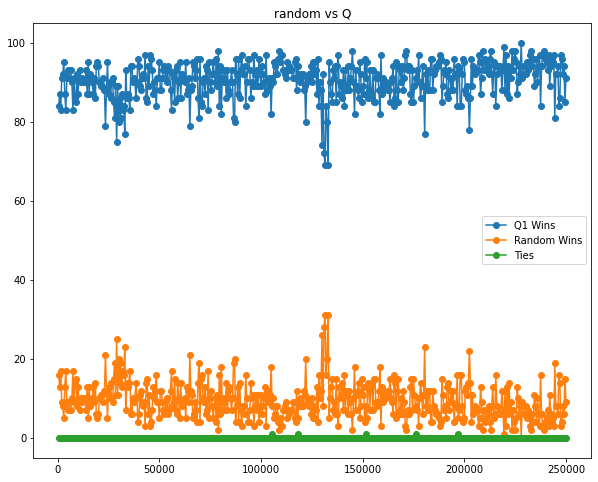

In [23]:
g=Game(number_of_games=1)  
g.display=True
g.run(Q1_agent,human_agent)

====
Game  1
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
Player 1 moves 3
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .   (r)   .    .    .  

  0    1    2    3    4    5    6
  7    8    9    10   11   12   13
  14   15   16   17   18   19   20
  21   22   23   24   25   26   27
  28   29   30   31   32   33   34
  35   36   37   38   39   40   41
     
 Your valid moves are:  [0, 1, 2, 3, 4, 5, 6]



 Where do you want to put your piece? You are yellow! 0


Player 2 moves 0
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
 (y)   .    .   (r)   .    .    .  
Player 1 moves 5
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
 (y)   .    .   (r)   .   (r)   .  

  0    1    2    3    4    5    6
  7    8    9    10   11   12   13
  14   15   16   17   18   19   20
  21   22   23   24   25   26   27
  28   29   30   31   32   33   34
  35   36   37   38   39   40   41
     
 Your valid moves are:  [0, 1, 2, 3, 4, 5, 6]



 Where do you want to put your piece? You are yellow! 3


Player 2 moves 3
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .   (y)   .    .    .  
 (y)   .    .   (r)   .   (r)   .  
Player 1 moves 3
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (y)   .    .    .  
 (y)   .    .   (r)   .   (r)   .  

  0    1    2    3    4    5    6
  7    8    9    10   11   12   13
  14   15   16   17   18   19   20
  21   22   23   24   25   26   27
  28   29   30   31   32   33   34
  35   36   37   38   39   40   41
     
 Your valid moves are:  [0, 1, 2, 3, 4, 5, 6]



 Where do you want to put your piece? You are yellow! 37


Illegal move.



 Where do you want to put your piece? You are yellow! 2


Player 2 moves 2
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (y)   .    .    .  
 (y)   .   (y)  (r)   .   (r)   .  
Player 1 moves 3
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (y)   .    .    .  
 (y)   .   (y)  (r)   .   (r)   .  

  0    1    2    3    4    5    6
  7    8    9    10   11   12   13
  14   15   16   17   18   19   20
  21   22   23   24   25   26   27
  28   29   30   31   32   33   34
  35   36   37   38   39   40   41
     
 Your valid moves are:  [0, 1, 2, 3, 4, 5, 6]



 Where do you want to put your piece? You are yellow! 4


Player 2 moves 4
  .    .    .    .    .    .    .  
  .    .    .    .    .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (y)   .    .    .  
 (y)   .   (y)  (r)  (y)  (r)   .  
Player 1 moves 3
  .    .    .    .    .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (y)   .    .    .  
 (y)   .   (y)  (r)  (y)  (r)   .  

  0    1    2    3    4    5    6
  7    8    9    10   11   12   13
  14   15   16   17   18   19   20
  21   22   23   24   25   26   27
  28   29   30   31   32   33   34
  35   36   37   38   39   40   41
     
 Your valid moves are:  [0, 1, 2, 3, 4, 5, 6]



 Where do you want to put your piece? You are yellow! 4


Player 2 moves 4
  .    .    .    .    .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (y)  (y)   .    .  
 (y)   .   (y)  (r)  (y)  (r)   .  
Player 1 moves 3
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (r)   .    .    .  
  .    .    .   (y)  (y)   .    .  
 (y)   .   (y)  (r)  (y)  (r)   .  
Player  1 won.


[1]